# Detection of Cardiac Arrhythmia from ECG Sequence

In the posted [1.2 version](https://cit.mak.ac.ug/staff/jquinn/software/lsanomaly.html) several demonstrations were included in the distribution. This notebook recreates the ECG demonstration.

This uses both the static (`predict_proba`) and sequence (`predict_sequence`) detection methods on ECG data. The specific data can be downloaded [here](http://www.physionet.org/cgi-bin/ATM) selecting Select MIT-BIH Arrhythmia Database ( _mitdb_ ), and export as a CSV.

The data was initially prepared from the CSV by applying a median filter with a kernel size of 301:
```
X = np.loadtxt(
    "data/MIT_physionet_sample.csv", skiprows=2, usecols=(1, 2), delimiter=","
)

# Apply a median filter with a window size of 301
X[:, 0] = X[:, 0] - scipy.signal.medfilt(X[:, 0], kernel_size=301)
X[:, 1] = X[:, 1] - scipy.signal.medfilt(X[:, 1], kernel_size=301)
```

For efficiency, the data used here has the median filter 
applied and is in `/notebooks/filtered_ecg.json`.

In [1]:
import os
import numpy as np
from pathlib import Path

cwd = os.getcwd()
os.chdir(Path(cwd).parents[1])

from lsanomaly import LSAnomaly
import lsanomaly.notebooks.dynamic as demo

### Data Prep

In [2]:
X_train, X_test = demo.data_prep(
    data_file=os.path.join(
        os.getcwd(), "lsanomaly", "notebooks", "filtered_ecg.json"
    )
)

## Anomaly Models

In [3]:
anomaly_model = LSAnomaly(rho=1, sigma=0.5)
anomaly_model.fit(X_train)

LSAnomaly(gamma=4.0,
          kernel_pos=array([[ 0.055,  0.05 ,  0.05 ,  0.03 ],
       [-0.03 , -0.05 ,  0.93 ,  0.66 ],
       [-0.355,  0.355, -3.16 , -2.985],
       ...,
       [ 0.235,  0.155,  0.865,  1.56 ],
       [-0.01 , -0.025, -0.255, -0.245],
       [ 0.09 ,  0.075,  0.765,  1.395]]),
          n_kernels_max=500, rho=1, seed=None, sigma=0.5)

### Static Detection

In [4]:
y_pred_static = anomaly_model.predict_proba(X_test)

### Dynamic Detection
Because the dynamic model uses an HMM, a state transition matrix $A$ 
and an initial probability vector $\pi$ are required.
We set

$$
\begin{equation*}
A = 
\begin{pmatrix}
0.999 & 0.001 \\
0.01 & 0.99 \\
\end{pmatrix}
\end{equation*}
$$
and
$$\pi = (0.5, .05)$$

In [5]:
A = np.array([[0.999, 0.001], [0.01, 0.99]])
pi = np.array([0.5, 0.5])

In [6]:
y_pred_dynamic = anomaly_model.predict_sequence(
    X_test, A, pi, inference="smoothing"
)

## RESULTS

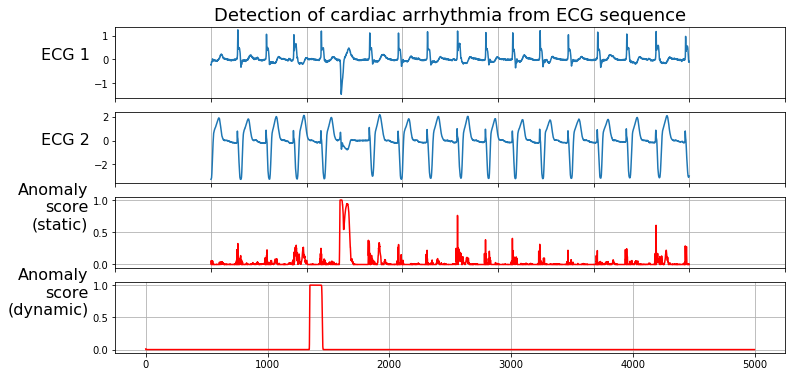

In [7]:
demo.plot_results(X_test, y_pred_static, y_pred_dynamic);